### Import dataset

In [127]:
import nltk
import math
import re
import pprint
import numpy as np
import matplotlib.pyplot as plt
corpusdir = "/home/tgeorgiopoulos/Dropbox/MSc Data Science/Year2_2/Text Analytics/ta_exercises_2018_19/en"
corpus = nltk.corpus.PlaintextCorpusReader(corpusdir, '.*')
corpus = corpus.raw()[:1000000]

### Bigram and Trigram model

#### 1. Convert corpus to  sentences and tokenize them

In [128]:
# Convert to lowercase all sentences
sentences = nltk.sent_tokenize(corpus)
sentences = [x.lower() for x in sentences]

# Remove tags
for i in range(0,len(sentences)):
    sentences[i] = re.compile(r'(?s)<.*?>').sub('', sentences[i])

# Tokenize sentences
whitespace_wt = nltk.WhitespaceTokenizer()
sentences_tokenized = []
for sent in sentences:
    sent_tok = whitespace_wt.tokenize(sent)
    sentences_tokenized.append(sent_tok)
    
# Extract tokens from tokenized sentences
tokens = []
for sent in sentences_tokenized:
    for token in sent:
        tokens.append(token)

# Compute tokens' frequencies and vocab size
fdist = nltk.FreqDist(tokens)
vocab_size = len(set(tokens))

print("The corpus has",len(sentences),"sentences and",vocab_size,"distinct words (tokens).")

The corpus has 6389 sentences and 13731 distinct words (tokens).


#### 2. Adding pseudo-tokens (*start*,*end*) in each sentence and replace OOV words

In [129]:
# Replace out of vocabulary words
for i in range(0,len(sentences_tokenized)):
    for j in range(0,len(sentences_tokenized[i])):
        if fdist[sentences_tokenized[i][j]] < 10:
            sentences_tokenized[i][j] = '*UNK*' 

# Tokenize the converted sentences
tokens = []
for sent in sentences_tokenized:
    for token in sent:
        tokens.append(token)

# Compute new tokens' frequencies and vocab size
fdist = nltk.FreqDist(tokens)
vocab_size = len(set(tokens))

print("After replacing OOV (out of vocabulary) words, there are now",vocab_size,"distinct words (tokens).")

After replacing OOV (out of vocabulary) words, there are now 1788 distinct words (tokens).


#### 3. Split in Training, Held-Out, and Test set

In [130]:
split_1 = int(0.8 * len(sentences_tokenized))
split_2 = int(0.9 * len(sentences_tokenized))
sentences_tok_train = sentences_tokenized[:split_1]
sentences_tok_held_out = sentences_tokenized[split_1:split_2]
sentences_tok_test = sentences_tokenized[split_2:]

#### 4. Training the model

In [131]:
# Adding *start* and *end* words for bigrams
sentences_tok_train_bigram = sentences_tok_train.copy()
for i in range(0,len(sentences_tok_train)):
    sentences_tok_train_bigram[i] = ['*start*'] + sentences_tok_train[i] + ['*end*']

# Compute bigram frequencies for training set          
bigram_counter = nltk.collections.Counter()
for words in sentences_tok_train_bigram:
    bigram_counter.update([gram for gram in nltk.bigrams(words)])
    
# Adding *start* and *end* words for trigrams
sentences_tok_train_trigram = sentences_tok_train.copy()
for i in range(0,len(sentences_tok_train)):
    sentences_tok_train_trigram[i] = ['*start1*'] + ['*start2*'] + sentences_tok_train[i] + ['*end1*'] + ['*end2*']

# Compute trigram frequencies for training set 
trigram_counter = nltk.collections.Counter()
for words in sentences_tok_train_trigram:
    trigram_counter.update([gram for gram in nltk.trigrams(words)])

#### 5. Hyper parameter tuning on held-out set

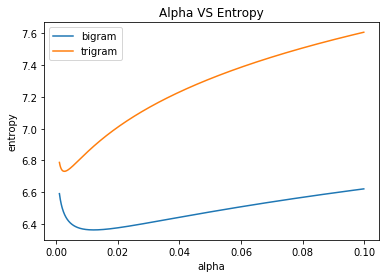

The best alpha for bigram model is 0.01210
The best alpha for trigram model is 0.00260


In [132]:
# Find the best alpha on a held-out dataset
alpha_list = list(np.arange(0.1 / (10 ** 2),0.1,0.1 / (10 ** 3)))

# Calculate entropies for bigrams and trigrams for different alpha values
entropy_values_bigram = []
entropy_values_trigram = []
for alpha in alpha_list:
    sum_prob_bigram = 0
    bigram_cnt = 0
    sum_prob_trigram = 0
    trigram_cnt = 0
    for sent in sentences_tok_held_out:
        sent_b = ['*start*'] + sent + ['*end*']
        sent_t = ['*start1*'] + ['*start2*'] +sent + ['*end1*'] + ['*end2*']
        for idx in range(1,len(sent_b)): 
            # bigram computations
            bigram_prob = (bigram_counter[(sent_b[idx-1], sent_b[idx])] +alpha)/ \
                          (fdist[(sent_b[idx-1])] + alpha*vocab_size)
            sum_prob_bigram += math.log2(bigram_prob)
            bigram_cnt+=1
        for idx in range(2,len(sent_t)):
            # trigram computations
            trigram_prob = (trigram_counter[(sent_t[idx-2],sent_t[idx-1], sent_t[idx])] +alpha)/ \
                           (bigram_counter[(sent_t[idx-2],sent_t[idx-1])] + alpha*vocab_size)
            sum_prob_trigram += math.log2(trigram_prob)
            trigram_cnt+=1
    entropy_values_bigram.append(-sum_prob_bigram / bigram_cnt)
    entropy_values_trigram.append(-sum_prob_trigram / trigram_cnt)

    
# These alphas correspond to the minimum entropies
alpha_bigram = alpha_list[entropy_values_bigram.index(min(entropy_values_bigram))]
alpha_trigram = alpha_list[entropy_values_trigram.index(min(entropy_values_trigram))]

# Plot entropy - alpha
plt.plot(alpha_list, entropy_values_bigram,label="bigram")
plt.ylabel('entropy')
plt.xlabel('alpha')
plt.title('Alpha VS Entropy')
plt.plot(alpha_list, entropy_values_trigram,label="trigram")
plt.legend(loc='best')
plt.show()

print("The best alpha for bigram model is {0:.5f}".format(alpha_bigram))
print("The best alpha for trigram model is {0:.5f}".format(alpha_trigram))

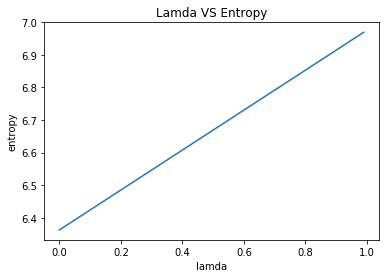

The best lamda for interpolated model is 0.000


In [133]:
# Find the best lambdas for interpolation
lamda_list = list(np.arange(0,1,0.01))

entropy_values_interpolation = []
for lamda in lamda_list:
    sum_prob_inter = 0
    ngram_cnt = 0
    for sent in sentences_tok_held_out:
        sum_prob_inter_bigram = 0
        sum_prob_inter_trigram = 0
        sent_b = ['*start*'] + sent + ['*end*']
        sent_t = ['*start1*'] + ['*start2*'] +sent + ['*end1*'] + ['*end2*']
        for idx in range(1,len(sent_b)):
            # bigram computations
            bigram_prob = (bigram_counter[(sent_b[idx-1], sent_b[idx])] +alpha_bigram) / \
                          (fdist[sent_b[idx-1]] + alpha_bigram*vocab_size)
            sum_prob_inter_bigram += (1-lamda) * math.log2(bigram_prob)
            ngram_cnt+=1 
        for idx in range(2,len(sent_t)):
            trigram_prob = (trigram_counter[(sent_t[idx-2],sent_t[idx-1],sent_t[idx])]+alpha_trigram) / \
                           (bigram_counter[(sent_t[idx-2],sent_t[idx-1])] + alpha_trigram*vocab_size)
            sum_prob_inter_trigram += lamda * math.log2(trigram_prob)
            
        sum_prob_inter += sum_prob_inter_bigram + sum_prob_inter_trigram
    entropy_values_interpolation.append(-sum_prob_inter / ngram_cnt)  
    
# Plot entropy - lamda
plt.plot(lamda_list, entropy_values_interpolation)
plt.ylabel('entropy')
plt.xlabel('lamda')
plt.title('Lamda VS Entropy')
plt.show()

# This lamda corresponds to the minimum entropies
lamda = lamda_list[entropy_values_interpolation.index(min(entropy_values_interpolation))]
print("The best lamda for interpolated model is {0:.3f}".format(lamda))

#### 6. Estimate language cross-entropy and perplexity on the test set

In [134]:
# Test set evaluations
sum_prob_bigram = 0
sum_prob_trigram = 0
sum_prob_inter = 0
bigram_cnt = 0
trigram_cnt = 0
ngram_cnt = 0
for sent in sentences_tok_test:
    sent_b = ['*start*'] + sent + ['*end*']
    sent_t = ['*start1*'] + ['*start2*'] +sent + ['*end1*'] + ['*end2*']
    for idx in range(1,len(sent_b)): 
        # bigram computations
        bigram_prob = (bigram_counter[(sent_b[idx-1], sent_b[idx])] +alpha_bigram)/ \
                      (fdist[(sent_b[idx-1])] + alpha_bigram*vocab_size)
        sum_prob_bigram += math.log2(bigram_prob)
        bigram_cnt+=1
    for idx in range(2,len(sent_t)):           
        # trigram computations
        trigram_prob = (trigram_counter[(sent_t[idx-2],sent_t[idx-1],sent_t[idx])] +alpha_trigram)/ \
                       (bigram_counter[(sent_t[idx-1],sent_t[idx])] + alpha_trigram*vocab_size)
        sum_prob_trigram += math.log2(trigram_prob)
        trigram_cnt+=1
        
# Compute entropies and perplexities
HC_bigram = -sum_prob_bigram / bigram_cnt
perpl_bigram = math.pow(2,HC_bigram)
HC_trigram = -sum_prob_trigram / trigram_cnt
perpl_trigram = math.pow(2,HC_trigram)

print("The Cross Entropy for the bigram model {0:.3f}".format(HC_bigram))
print("The perplexity for the bigram model is {0:.3f}".format(perpl_bigram))
print("The Cross Entropy for the trigram model {0:.3f}".format(HC_trigram))
print("The perplexity for the trigram model is {0:.3f}".format(perpl_trigram))

The Cross Entropy for the bigram model 6.497
The perplexity for the bigram model is 90.320
The Cross Entropy for the trigram model 6.878
The perplexity for the trigram model is 117.621
